In [16]:
import numpy as np
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm
from mpl_toolkits import mplot3d
import time

In [17]:
from rawFLIR_polarization_data_extraction import *
from slope2height import *

In [18]:
NUM_IMAGES=1
BEDFORM = 'corals'
file_location = "../FLIR_Camera/"+BEDFORM+"_fastFlow_ShallowH_test1_centeredCam_flume_LookAngle_35Deg"
ref_image_name = 'reference.tiff'
figures_location = "../FLIR_Camera/"+BEDFORM+"_fastFlow_ShallowH_test1_centeredCam_flume_LookAngle_35Deg_FIGURES"
height_figs_location  = "../FLIR_Camera/"+BEDFORM+"_fastFlow_ShallowH_test1_centeredCam_flume_LookAngle_35Deg_HEIGHT_FIGURES"
save_location =  "../FLIR_Camera"
data_filename = BEDFORM + "_fastFlow_ShallowH_test1.pickle"
dark_files_location = "../FLIR_Camera/dark_imgs"
flat_files_location = "../FLIR_Camera/flat_imgs"

In [19]:
filenames = os.listdir(file_location)
filenames.remove(ref_image_name) 

In [20]:
print(len(filenames))

69


Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0419774055480957 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.052970170974731445 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


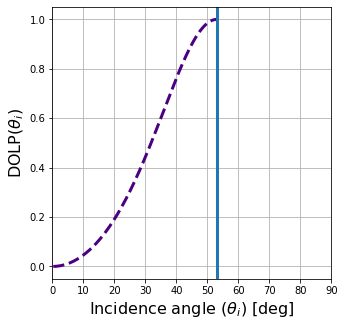

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  30.2487370967865 seconds
False
AoLP time:  0.051970720291137695 s


In [21]:
im_theta1, im_phi1 = theta_phi(ref_image_name, file_location,
                               material = 'water',
                               flat_field_correct = 1,
                               gaussian_smoothing_sigma = 0,
                               dark_files_location= dark_files_location, flat_files_location= flat_files_location,
                               num_images= NUM_IMAGES, correction_angle=0)


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.041975975036621094 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.05096864700317383 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


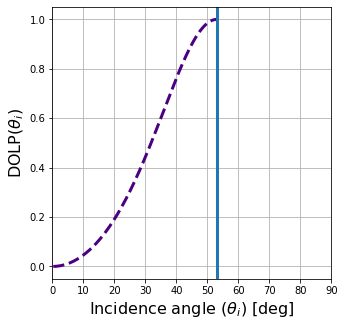

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  32.16858720779419 seconds
False
AoLP time:  0.05896568298339844 s



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.32s/it]

In [22]:
for filename2 in tqdm(filenames[0:1]): #
    im_theta2, im_phi2 = theta_phi(filename2, file_location,
                               material = 'water',
                               flat_field_correct = 1,
                               gaussian_smoothing_sigma = 0,
                               dark_files_location= dark_files_location, flat_files_location= flat_files_location,
                               num_images= NUM_IMAGES, correction_angle=0)

    raw_img2 = cv2.imread(os.path.join(file_location, filename2))

<Figure size 432x288 with 0 Axes>

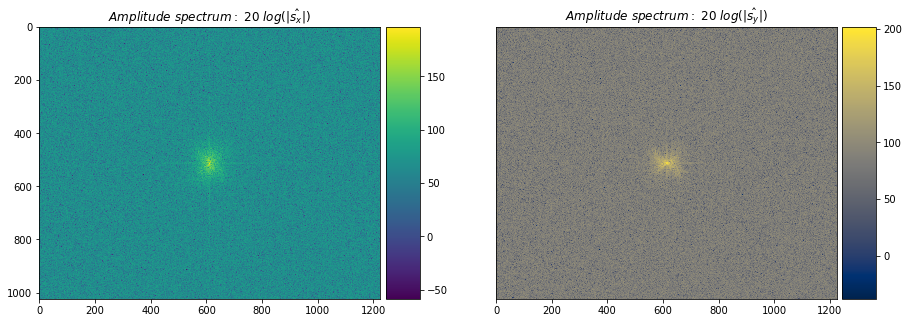

<Figure size 432x288 with 0 Axes>

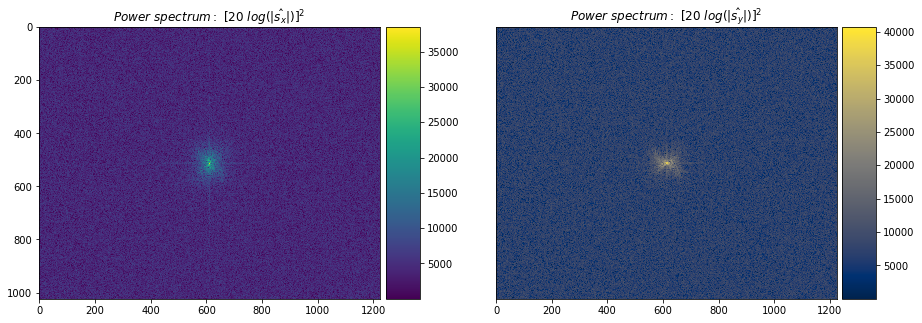

In [23]:
s_x = np.tan(np.radians((im_theta2 - im_theta1)))
s_y = np.tan(np.radians((im_phi2 - im_phi1)))
s_hat_x, s_hat_y = slopeFieldFFT(s_x, s_y)
height_map = slope2height(s_hat_x, s_hat_y)

<Figure size 432x288 with 0 Axes>

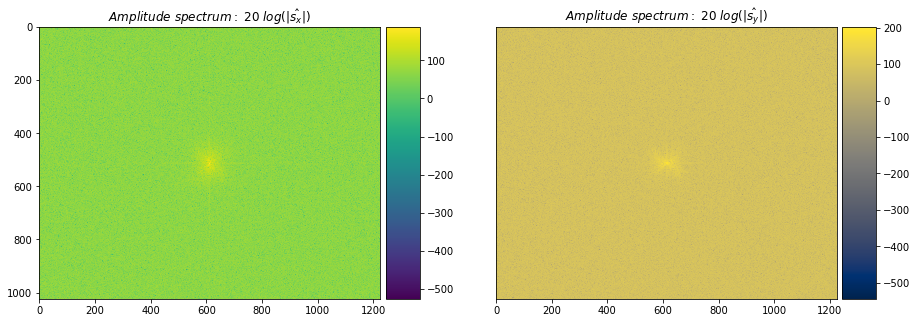

<Figure size 432x288 with 0 Axes>

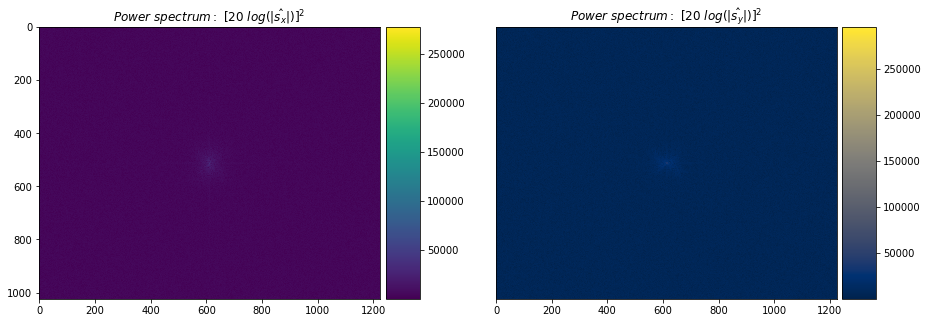

In [24]:
s_hat_x_noDC, s_hat_y_noDC = slopeFieldFFT(s_x - np.mean(s_x), s_y - np.mean(s_y))

When the input a is a time-domain signal and A = fft(a), np.abs(A) is its amplitude spectrum and np.abs(A)**2 is its power spectrum. The phase spectrum is obtained by np.angle(A).

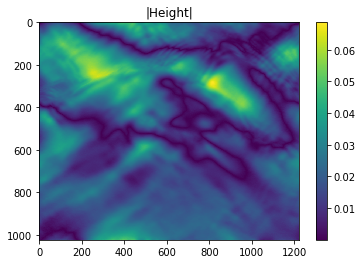

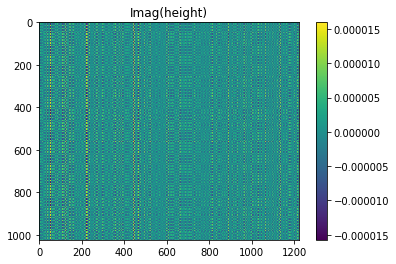

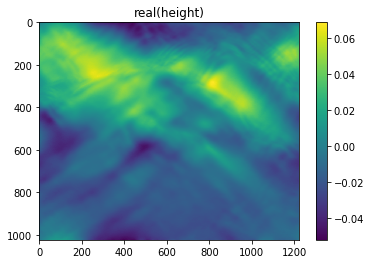

In [25]:
plt.figure()
plt.imshow(np.abs(height_map))
plt.colorbar()
plt.title('|Height|')
plt.show()

plt.figure()
plt.imshow(np.imag(height_map))
plt.colorbar()
plt.title('Imag(height)')
plt.show()

plt.figure()
plt.imshow(np.real(height_map))
plt.colorbar()
plt.title('real(height)')
plt.show()



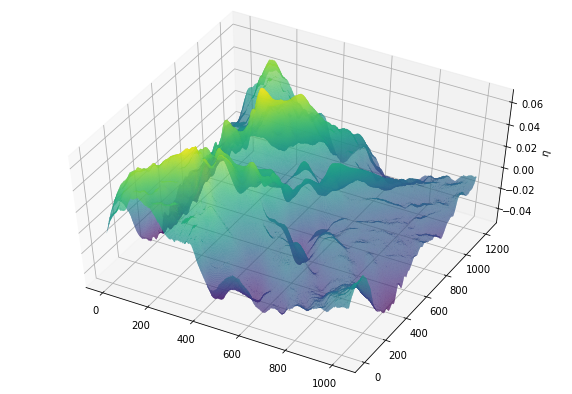

42.303680658340454


In [26]:
# %matplotlib widget
rows, cols = s_x.shape
Z = np.real(height_map)
X,Y = np.meshgrid(np.arange(0,cols), np.arange(0,rows))

fig = plt.figure(figsize = (10,7)) 
  
# syntax for 3-D plotting 
ax = plt.axes(projection ='3d') 

tic = time.time()
# syntax for plotting 
p = ax.plot_surface(Y, X, Z, cmap ='viridis', rstride = 2, cstride = 2)#, edgecolor ='green') 
# ax.set_title('Height map')
ax.set_zlabel('$\\eta$')
ax.view_init(azim = -61, elev = 52)
plt.show() 
toc = time.time()
print(toc-tic)

# SAVE the height, slope, raw data maps

In [27]:
all_height_maps = np.zeros((im_theta1.shape[0],im_theta1.shape[1],len(filenames)))
all_sx_maps = np.zeros((im_theta1.shape[0],im_theta1.shape[1],len(filenames)))
all_sy_maps = np.zeros((im_theta1.shape[0],im_theta1.shape[1],len(filenames)))
all_raw_frames_0filter = np.zeros((im_theta1.shape[0],im_theta1.shape[1],len(filenames)))


  0%|                                                                                           | 0/69 [00:00<?, ?it/s]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.034979820251464844 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04697275161743164 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


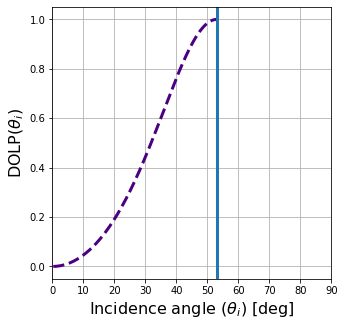

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  28.04176640510559 seconds
False
AoLP time:  0.04297614097595215 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

  1%|█▏                                                                                 | 1/69 [00:35<40:41, 35.91s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.033980607986450195 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04397439956665039 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


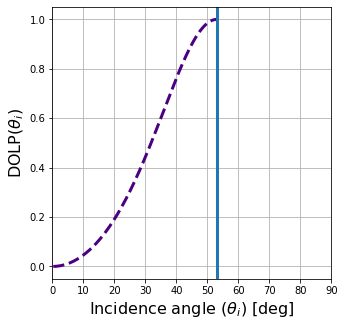

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  24.170684099197388 seconds
False
AoLP time:  0.04097628593444824 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

  3%|██▍                                                                                | 2/69 [01:07<38:39, 34.62s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.031980276107788086 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03298163414001465 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


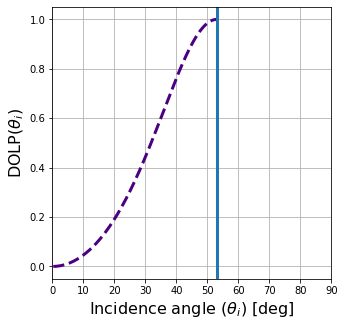

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  23.29445171356201 seconds
False
AoLP time:  0.04197406768798828 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

  4%|███▌                                                                               | 3/69 [01:35<35:56, 32.68s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03098154067993164 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04297518730163574 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


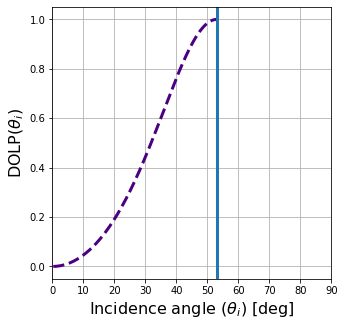

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  23.899091005325317 seconds
False
AoLP time:  0.045973777770996094 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

  6%|████▊                                                                              | 4/69 [02:04<34:10, 31.54s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02898240089416504 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04197525978088379 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


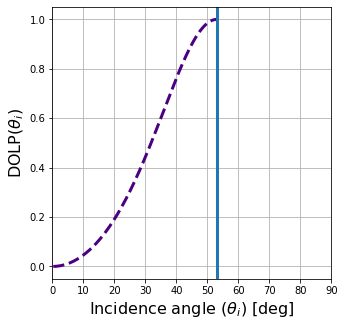

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  24.313143491744995 seconds
False
AoLP time:  0.04697132110595703 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

  7%|██████                                                                             | 5/69 [02:34<33:04, 31.01s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028983354568481445 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.038976430892944336 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


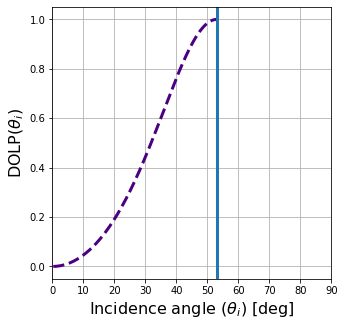

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  22.074840784072876 seconds
False
AoLP time:  0.05596613883972168 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

  9%|███████▏                                                                           | 6/69 [03:01<31:19, 29.84s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027983903884887695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.038976192474365234 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


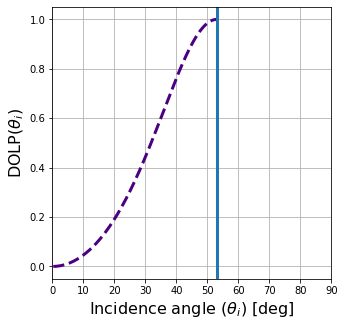

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  24.813867807388306 seconds
False
AoLP time:  0.04197502136230469 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 10%|████████▍                                                                          | 7/69 [03:31<30:46, 29.79s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02798295021057129 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03897738456726074 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


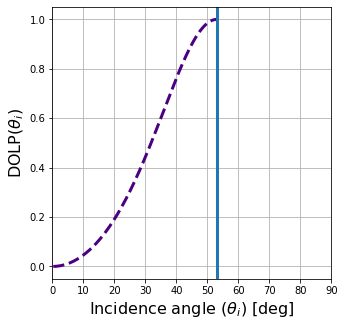

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  22.523255825042725 seconds
False
AoLP time:  0.04497480392456055 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 12%|█████████▌                                                                         | 8/69 [03:58<29:32, 29.06s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027985811233520508 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597855567932129 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


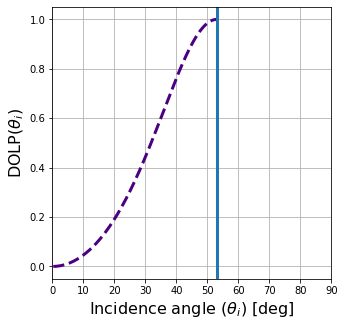

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  24.04202628135681 seconds
False
AoLP time:  0.040975093841552734 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 13%|██████████▊                                                                        | 9/69 [04:27<29:02, 29.04s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.033980607986450195 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.036977291107177734 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


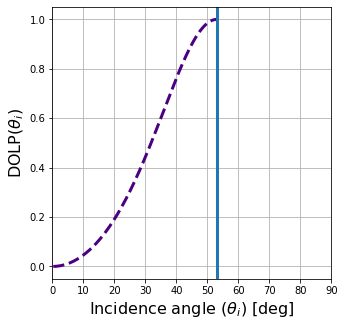

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  23.762578010559082 seconds
False
AoLP time:  0.0419771671295166 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 14%|███████████▉                                                                      | 10/69 [04:56<28:29, 28.97s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028981685638427734 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03897714614868164 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


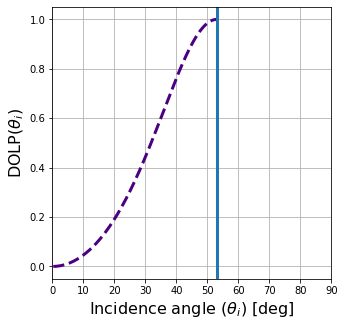

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  26.290613174438477 seconds
False
AoLP time:  0.04996967315673828 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 16%|█████████████                                                                     | 11/69 [05:27<28:41, 29.68s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.030982017517089844 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04197573661804199 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


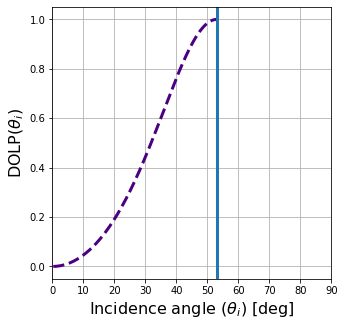

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  25.997499227523804 seconds
False
AoLP time:  0.04697227478027344 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 17%|██████████████▎                                                                   | 12/69 [05:58<28:40, 30.18s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028982162475585938 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.038976430892944336 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


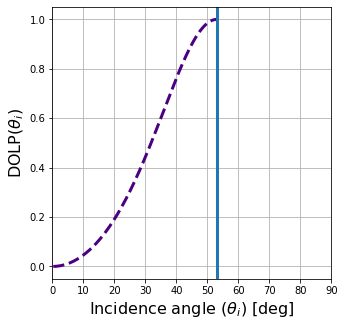

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  24.600434064865112 seconds
False
AoLP time:  0.04097628593444824 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 19%|███████████████▍                                                                  | 13/69 [06:28<28:07, 30.13s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.04397130012512207 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04097580909729004 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


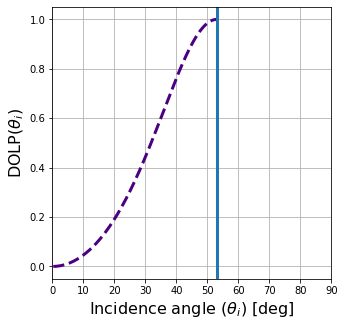

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  25.804924964904785 seconds
False
AoLP time:  0.04197335243225098 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 20%|████████████████▋                                                                 | 14/69 [07:00<27:53, 30.43s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03198099136352539 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.041974782943725586 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


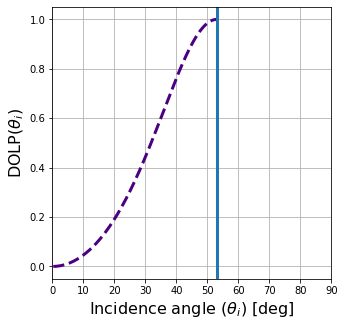

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  25.602737188339233 seconds
False
AoLP time:  0.041974782943725586 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 22%|█████████████████▊                                                                | 15/69 [07:31<27:31, 30.58s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.031983375549316406 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04497408866882324 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


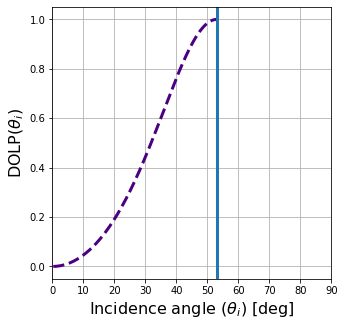

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  25.632559537887573 seconds
False
AoLP time:  0.049970388412475586 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 23%|███████████████████                                                               | 16/69 [08:02<27:07, 30.70s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028982162475585938 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03997611999511719 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


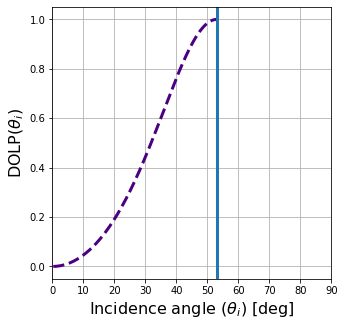

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  24.805541276931763 seconds
False
AoLP time:  0.040976762771606445 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 25%|████████████████████▏                                                             | 17/69 [08:32<26:25, 30.49s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.029983043670654297 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03997635841369629 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


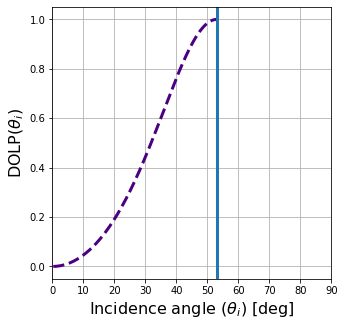

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  26.64826273918152 seconds
False
AoLP time:  0.046973228454589844 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 26%|█████████████████████▍                                                            | 18/69 [09:03<26:16, 30.92s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03298044204711914 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03897738456726074 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


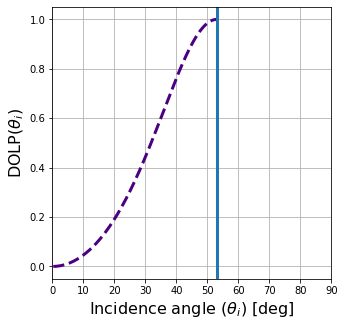

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  25.085798025131226 seconds
False
AoLP time:  0.054965972900390625 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 28%|██████████████████████▌                                                           | 19/69 [09:34<25:36, 30.72s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.029982328414916992 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.0399775505065918 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


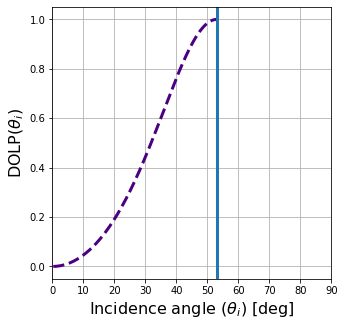

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  25.096015214920044 seconds
False
AoLP time:  0.04197525978088379 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 29%|███████████████████████▊                                                          | 20/69 [10:04<24:59, 30.60s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.029984474182128906 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04297494888305664 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


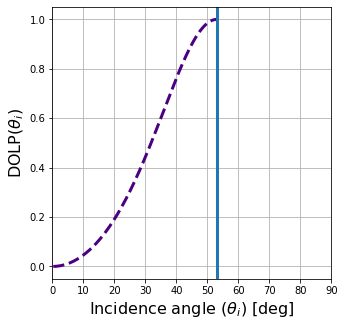

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  27.297572374343872 seconds
False
AoLP time:  0.047971248626708984 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 30%|████████████████████████▉                                                         | 21/69 [10:37<24:56, 31.18s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.033980607986450195 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697800636291504 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


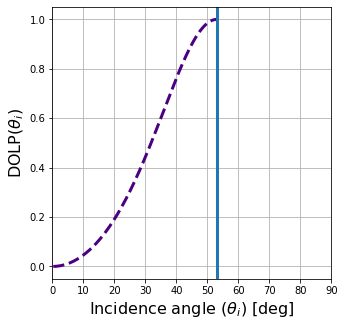

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  26.62282395362854 seconds
False
AoLP time:  0.058966636657714844 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 32%|██████████████████████████▏                                                       | 22/69 [11:09<24:36, 31.41s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.029982566833496094 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.037978172302246094 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


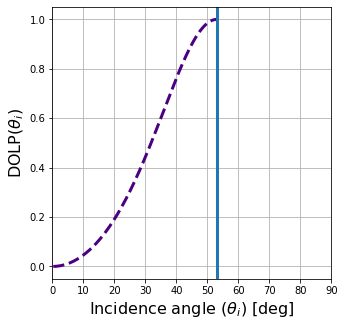

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  27.290616512298584 seconds
False
AoLP time:  0.051969289779663086 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 33%|███████████████████████████▎                                                      | 23/69 [11:41<24:21, 31.78s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03298163414001465 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04697251319885254 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


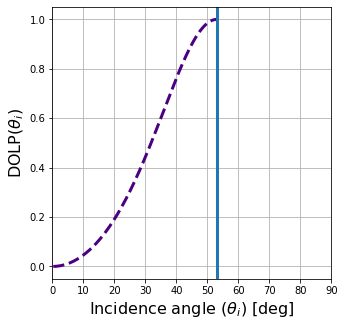

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  26.484761238098145 seconds
False
AoLP time:  0.06247377395629883 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 35%|████████████████████████████▌                                                     | 24/69 [12:13<23:51, 31.81s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.029982328414916992 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.06296372413635254 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


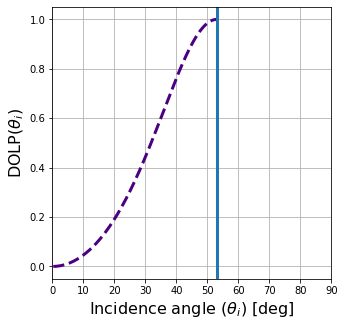

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  24.67354393005371 seconds
False
AoLP time:  0.04797196388244629 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 36%|█████████████████████████████▋                                                    | 25/69 [12:43<22:54, 31.25s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.031981468200683594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.038976192474365234 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


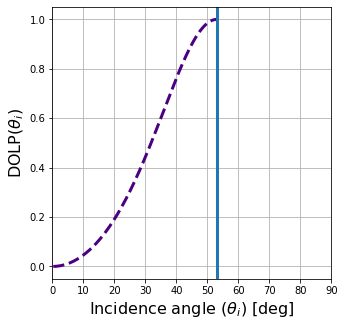

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  24.3366117477417 seconds
False
AoLP time:  0.04197525978088379 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 38%|██████████████████████████████▉                                                   | 26/69 [13:12<21:59, 30.68s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028983354568481445 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.036978960037231445 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


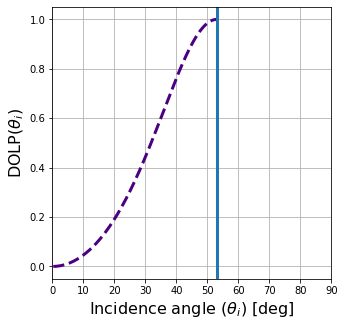

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  24.857727527618408 seconds
False
AoLP time:  0.03897809982299805 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 39%|████████████████████████████████                                                  | 27/69 [13:42<21:19, 30.46s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028983116149902344 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697848320007324 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


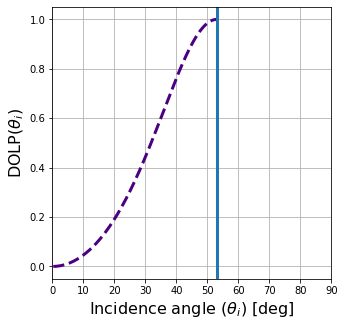

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  23.725836515426636 seconds
False
AoLP time:  0.04497170448303223 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 41%|█████████████████████████████████▎                                                | 28/69 [14:11<20:28, 29.96s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0279843807220459 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03797745704650879 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


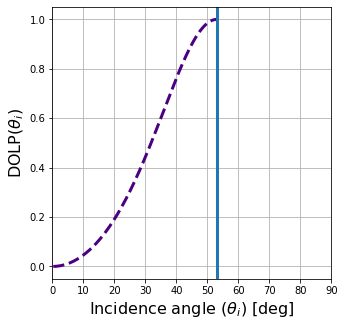

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  26.20839285850525 seconds
False
AoLP time:  0.05196833610534668 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 42%|██████████████████████████████████▍                                               | 29/69 [14:42<20:14, 30.36s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.030985355377197266 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04597306251525879 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


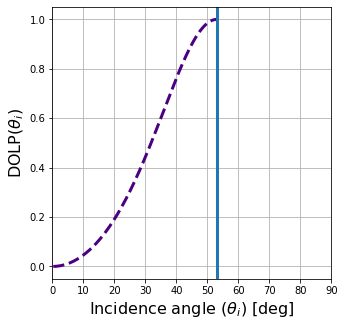

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  23.467674016952515 seconds
False
AoLP time:  0.046973466873168945 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 43%|███████████████████████████████████▋                                              | 30/69 [15:11<19:26, 29.91s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.0259857177734375 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.034979820251464844 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


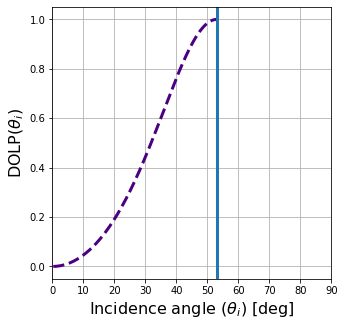

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  23.243576765060425 seconds
False
AoLP time:  0.04097557067871094 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 45%|████████████████████████████████████▊                                             | 31/69 [15:39<18:37, 29.42s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.029983043670654297 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.037978410720825195 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


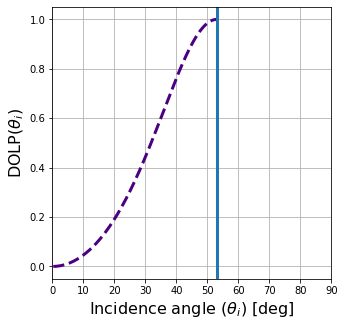

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  26.056827783584595 seconds
False
AoLP time:  0.0419774055480957 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 46%|██████████████████████████████████████                                            | 32/69 [16:11<18:26, 29.90s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02698516845703125 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.035980224609375 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


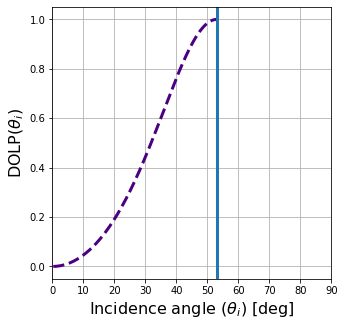

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  25.15871787071228 seconds
False
AoLP time:  0.0399775505065918 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 48%|███████████████████████████████████████▏                                          | 33/69 [16:41<18:00, 30.01s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.029982805252075195 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04699540138244629 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


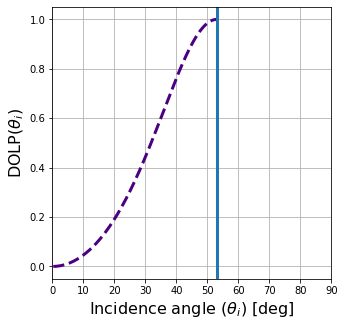

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  26.783586025238037 seconds
False
AoLP time:  0.0539860725402832 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 49%|████████████████████████████████████████▍                                         | 34/69 [17:13<17:53, 30.68s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.029982328414916992 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03698015213012695 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


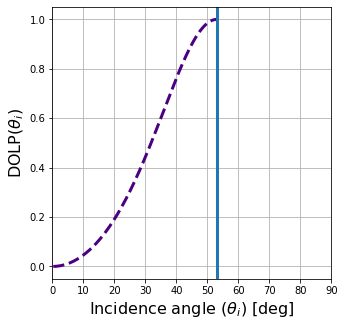

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  25.972301721572876 seconds
False
AoLP time:  0.03997683525085449 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 51%|█████████████████████████████████████████▌                                        | 35/69 [17:44<17:28, 30.83s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03198122978210449 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03897833824157715 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


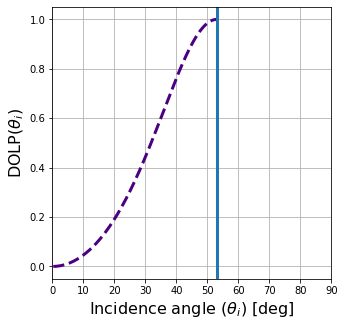

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  26.86884903907776 seconds
False
AoLP time:  0.04796242713928223 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 52%|██████████████████████████████████████████▊                                       | 36/69 [18:16<17:08, 31.18s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02898383140563965 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.035161495208740234 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


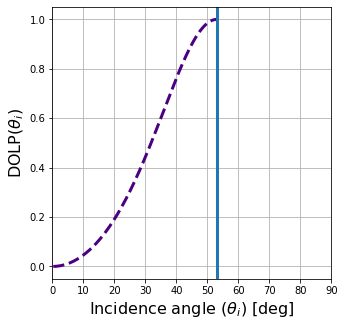

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  25.731079816818237 seconds
False
AoLP time:  0.047972917556762695 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 54%|███████████████████████████████████████████▉                                      | 37/69 [18:47<16:34, 31.08s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03298068046569824 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.036977291107177734 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


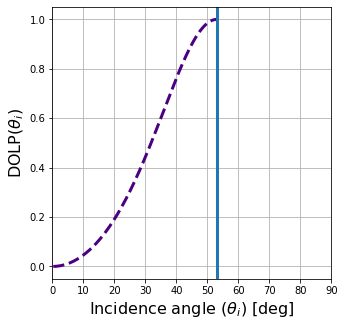

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  25.851135730743408 seconds
False
AoLP time:  0.048972129821777344 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 55%|█████████████████████████████████████████████▏                                    | 38/69 [19:19<16:09, 31.26s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03098154067993164 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.040975332260131836 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


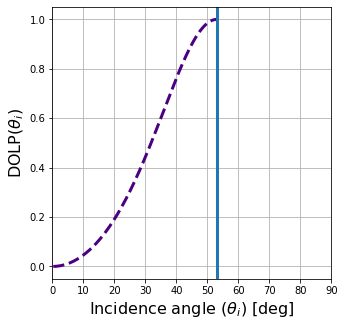

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  26.79548478126526 seconds
False
AoLP time:  0.0439753532409668 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 57%|██████████████████████████████████████████████▎                                   | 39/69 [19:51<15:47, 31.60s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.035979509353637695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.040976762771606445 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


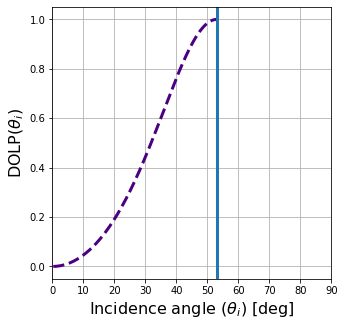

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  24.948586225509644 seconds
False
AoLP time:  0.04997086524963379 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 58%|███████████████████████████████████████████████▌                                  | 40/69 [20:21<15:05, 31.21s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03098154067993164 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.0479733943939209 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


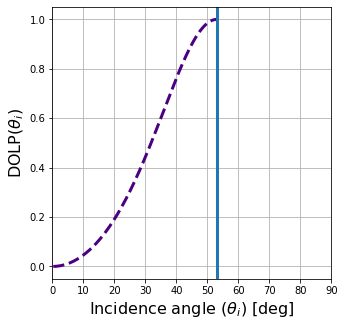

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  24.387866258621216 seconds
False
AoLP time:  0.04097723960876465 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 59%|████████████████████████████████████████████████▋                                 | 41/69 [20:51<14:19, 30.70s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02698540687561035 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.035977840423583984 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


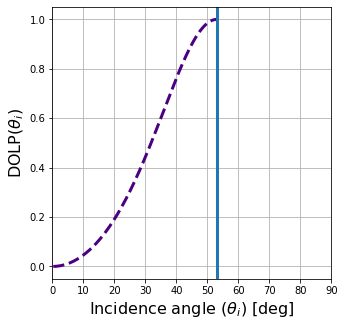

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  23.53955340385437 seconds
False
AoLP time:  0.04097795486450195 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 61%|█████████████████████████████████████████████████▉                                | 42/69 [21:19<13:31, 30.04s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027984142303466797 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597831726074219 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


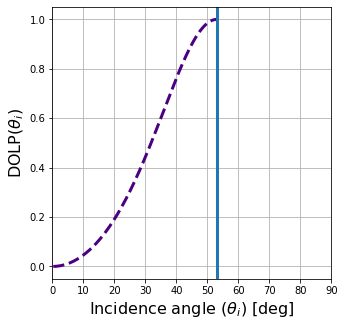

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  24.12940788269043 seconds
False
AoLP time:  0.045974016189575195 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 62%|███████████████████████████████████████████████████                               | 43/69 [21:49<12:54, 29.78s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028983116149902344 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03997659683227539 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


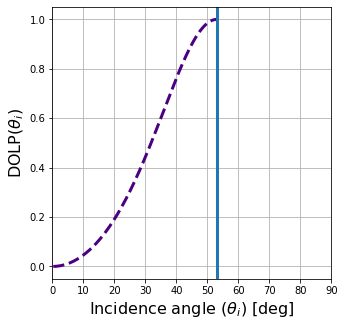

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  23.093702793121338 seconds
False
AoLP time:  0.04197525978088379 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 64%|████████████████████████████████████████████████████▎                             | 44/69 [22:17<12:12, 29.30s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.028982877731323242 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04397439956665039 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


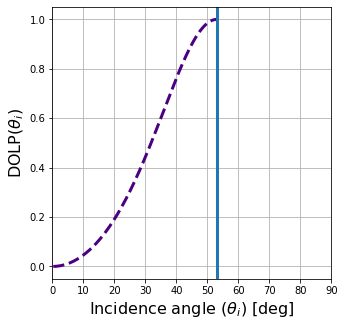

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  29.624807357788086 seconds
False
AoLP time:  0.04597139358520508 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 65%|█████████████████████████████████████████████████████▍                            | 45/69 [22:52<12:22, 30.95s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.029982566833496094 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.040975332260131836 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


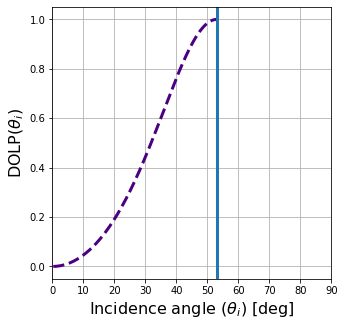

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  26.202378273010254 seconds
False
AoLP time:  0.055966854095458984 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 67%|██████████████████████████████████████████████████████▋                           | 46/69 [23:23<11:58, 31.24s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.03298234939575195 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.04197549819946289 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


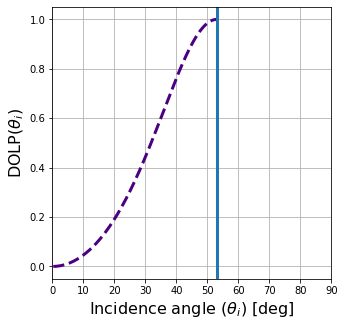

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  21.359294891357422 seconds
False
AoLP time:  0.04097580909729004 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 68%|███████████████████████████████████████████████████████▊                          | 47/69 [23:50<10:54, 29.75s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986339569091797 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03398013114929199 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


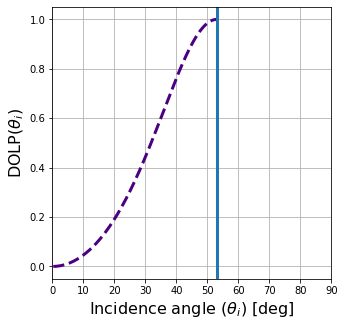

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  21.843539237976074 seconds
False
AoLP time:  0.03896927833557129 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 70%|█████████████████████████████████████████████████████████                         | 48/69 [24:16<10:01, 28.65s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.02698373794555664 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.030983448028564453 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


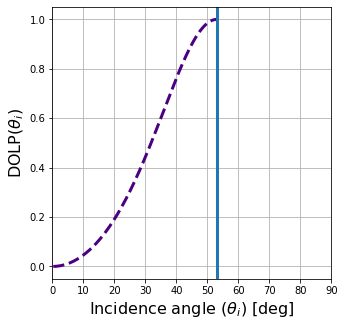

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  21.74781084060669 seconds
False
AoLP time:  0.03997468948364258 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 71%|██████████████████████████████████████████████████████████▏                       | 49/69 [24:42<09:16, 27.84s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023985862731933594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.033493995666503906 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


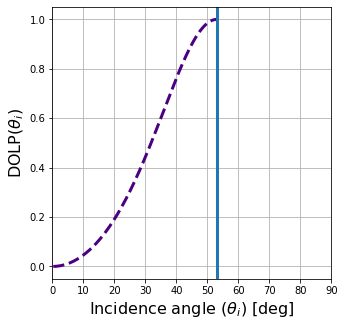

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  21.30065894126892 seconds
False
AoLP time:  0.04397439956665039 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 72%|███████████████████████████████████████████████████████████▍                      | 50/69 [25:07<08:35, 27.14s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986339569091797 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597831726074219 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


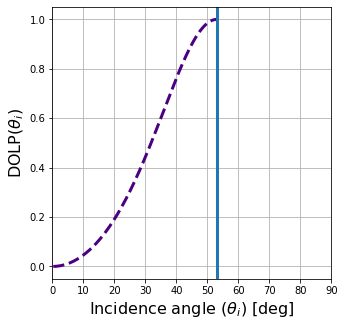

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  21.380647897720337 seconds
False
AoLP time:  0.037978172302246094 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 74%|████████████████████████████████████████████████████████████▌                     | 51/69 [25:33<08:00, 26.70s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985313415527344 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03098130226135254 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


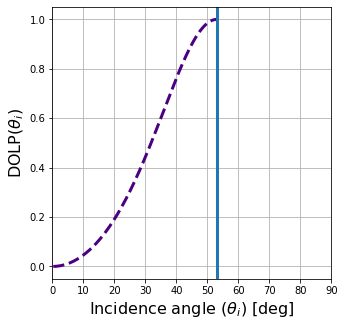

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  21.540239334106445 seconds
False
AoLP time:  0.03896641731262207 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 75%|█████████████████████████████████████████████████████████████▊                    | 52/69 [25:59<07:28, 26.39s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026983261108398438 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.033980369567871094 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


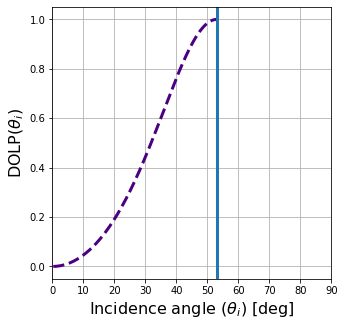

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  21.58193325996399 seconds
False
AoLP time:  0.041975975036621094 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 77%|██████████████████████████████████████████████████████████████▉                   | 53/69 [26:24<06:59, 26.21s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986101150512695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597903251647949 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


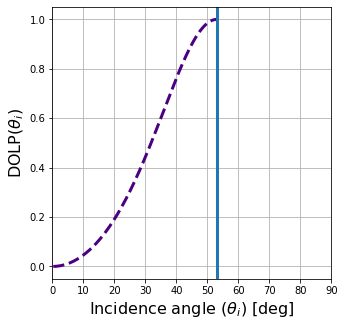

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  21.371656894683838 seconds
False
AoLP time:  0.04597353935241699 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 78%|████████████████████████████████████████████████████████████████▏                 | 54/69 [26:50<06:30, 26.04s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986339569091797 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.032979726791381836 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


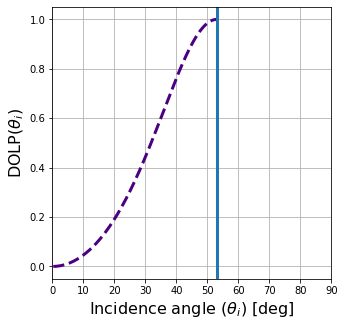

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  22.62084460258484 seconds
False
AoLP time:  0.041975975036621094 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 80%|█████████████████████████████████████████████████████████████████▎                | 55/69 [27:17<06:07, 26.28s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.029983043670654297 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03597831726074219 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


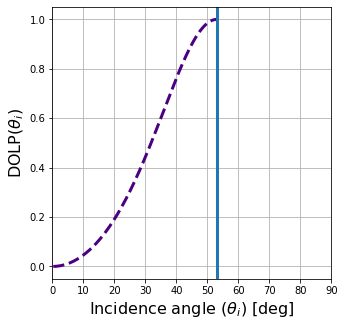

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  22.777148485183716 seconds
False
AoLP time:  0.037978172302246094 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 81%|██████████████████████████████████████████████████████████████████▌               | 56/69 [27:44<05:45, 26.60s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026983976364135742 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697824478149414 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


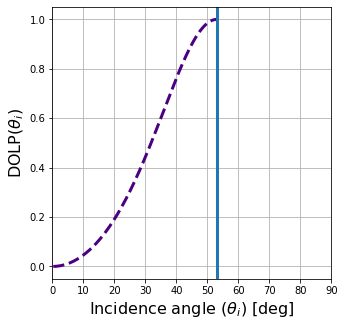

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  21.722044467926025 seconds
False
AoLP time:  0.03897714614868164 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 83%|███████████████████████████████████████████████████████████████████▋              | 57/69 [28:10<05:16, 26.38s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023986101150512695 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.033978939056396484 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


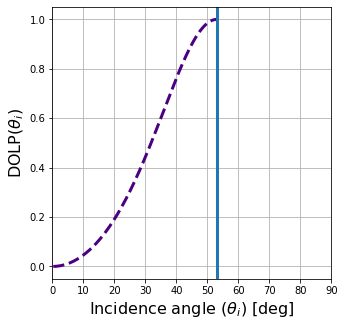

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  21.110188007354736 seconds
False
AoLP time:  0.03898000717163086 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 84%|████████████████████████████████████████████████████████████████████▉             | 58/69 [28:35<04:46, 26.06s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026984453201293945 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.035980224609375 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


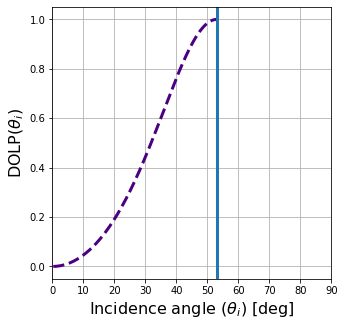

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  21.264151096343994 seconds
False
AoLP time:  0.03797769546508789 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 86%|██████████████████████████████████████████████████████████████████████            | 59/69 [29:01<04:18, 25.88s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025984764099121094 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697776794433594 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


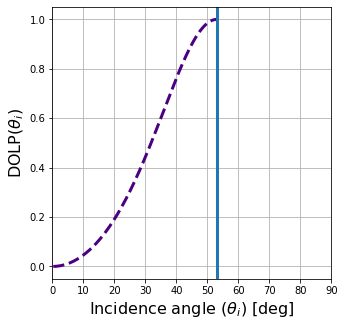

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  20.92345404624939 seconds
False
AoLP time:  0.03897690773010254 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 87%|███████████████████████████████████████████████████████████████████████▎          | 60/69 [29:26<03:50, 25.65s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026982545852661133 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.031982421875 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


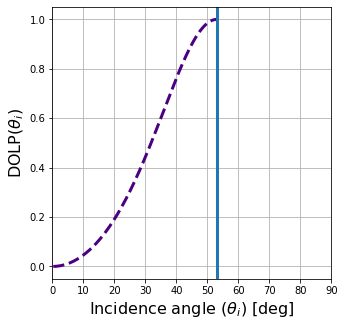

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  22.327606439590454 seconds
False
AoLP time:  0.03997683525085449 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 88%|████████████████████████████████████████████████████████████████████████▍         | 61/69 [29:53<03:27, 25.92s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.027984142303466797 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697824478149414 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


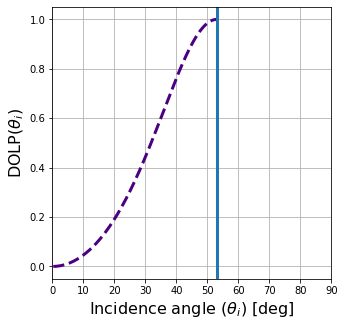

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  23.337369918823242 seconds
False
AoLP time:  0.03897690773010254 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 90%|█████████████████████████████████████████████████████████████████████████▋        | 62/69 [30:20<03:05, 26.52s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026984453201293945 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03497910499572754 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


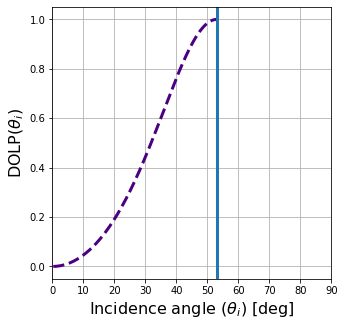

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  23.06582999229431 seconds
False
AoLP time:  0.03996753692626953 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 91%|██████████████████████████████████████████████████████████████████████████▊       | 63/69 [30:48<02:40, 26.79s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.026983261108398438 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03697848320007324 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


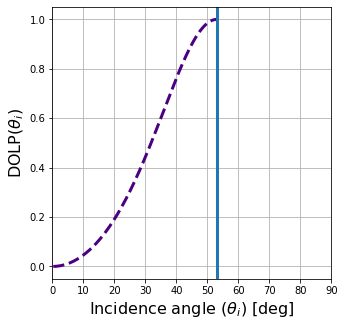

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  22.358076333999634 seconds
False
AoLP time:  0.04397439956665039 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 93%|████████████████████████████████████████████████████████████████████████████      | 64/69 [31:15<02:13, 26.74s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.033982038497924805 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03897714614868164 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


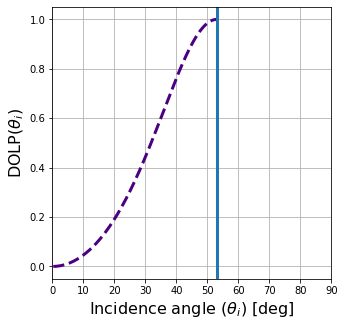

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  22.344977378845215 seconds
False
AoLP time:  0.047971487045288086 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 94%|█████████████████████████████████████████████████████████████████████████████▏    | 65/69 [31:41<01:47, 26.80s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.030981779098510742 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03997659683227539 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


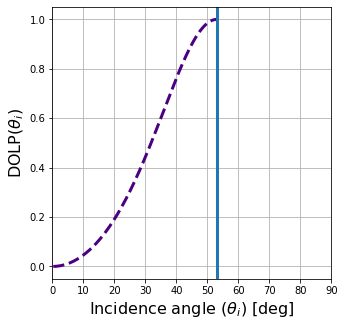

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  22.897582530975342 seconds
False
AoLP time:  0.03997659683227539 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 96%|██████████████████████████████████████████████████████████████████████████████▍   | 66/69 [32:09<01:20, 26.99s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.023985862731933594 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.03297996520996094 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


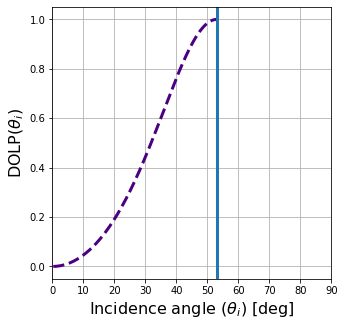

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  23.374311208724976 seconds
False
AoLP time:  0.04397249221801758 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 97%|███████████████████████████████████████████████████████████████████████████████▌  | 67/69 [32:37<00:54, 27.21s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.024985074996948242 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.036980390548706055 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


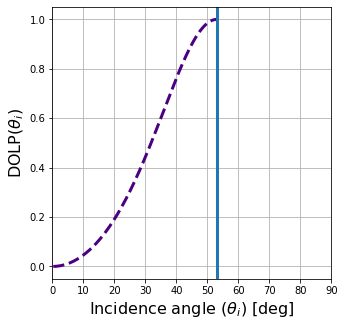

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  22.84451174736023 seconds
False
AoLP time:  0.04097461700439453 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

 99%|████████████████████████████████████████████████████████████████████████████████▊ | 68/69 [33:04<00:27, 27.25s/it]

Processing data for material : WATER
image_data shape is :  (2048, 2448)
im90 shape is :  (1024, 1224)
Stokes time:  0.025985002517700195 s
im_stokes0 shape is :  (1024, 1224)
DoLP time:  0.031981468200683594 s
im_DOLP shape is :  (1024, 1224)


C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:228: RuntimeWarning: invalid value encountered in true_divide
  alpha = 0.5*(np.tan(thI-thT)/np.tan(thI+thT))**2
C:\Users\tracy\Downloads\saksham_polarimetric_cam\scripts\rawFLIR_polarization_data_extraction.py:229: RuntimeWarning: invalid value encountered in true_divide
  eta = 0.5*(np.sin(thI-thT)/np.sin(thI+thT))**2


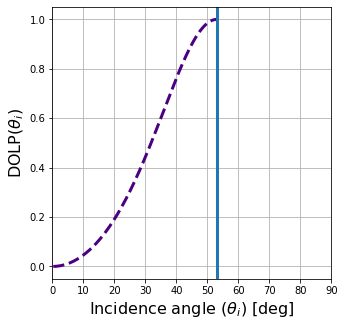

C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]


Time for DOLP2Theta conversion is :  23.494044303894043 seconds
False
AoLP time:  0.04097628593444824 s


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part

100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [33:32<00:00, 27.42s/it]

In [28]:
i=-1
cumul_height_map = np.zeros(im_theta1.shape, dtype = 'complex')
for filename2 in tqdm(filenames): #
    i+=1
    im_theta2, im_phi2 = theta_phi(filename2, file_location,
                               material = 'water',
                               flat_field_correct = 1,
                               gaussian_smoothing_sigma = 0,
                               dark_files_location= dark_files_location, flat_files_location= flat_files_location,
                               num_images= NUM_IMAGES, correction_angle=0)

    raw_img2 = cv2.imread(os.path.join(file_location, filename2))
    
    # get slopes and height maps
    s_x = np.tan(np.radians((im_theta2 - im_theta1)))
    s_y = np.tan(np.radians((im_phi2 - im_phi1)))
    s_hat_x, s_hat_y = slopeFieldFFT(s_x, s_y, suppress_fig = 1)
    height_map = slope2height(s_hat_x, s_hat_y)
    all_height_maps[:,:,i] = height_map
    all_sx_maps[:,:,i] = s_x
    all_sy_maps[:,:,i] = s_y
    all_raw_frames_0filter[:,:,i] = raw_img2[::2,::2,0]

In [29]:
all_data_dict = {'all_height_maps': all_height_maps, 'all_sx_maps': all_sx_maps, \
                 'all_sy_maps':all_sy_maps, 'all_raw_frames_0filter':all_raw_frames_0filter}

tic = time.time()
with open(os.path.join(save_location,data_filename), 'wb') as handle:
    pickle.dump(all_data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
print('time taken = ', time.time() - tic)

time taken =  9.084932088851929


In [30]:
# for k in all_data_dict_loaded.keys():
#     print(all_data_dict_loaded[k].all() == all_data_dict[k].all())

In [31]:
# time_mean_height_map = cumul_height_map/len(filenames)

## Plot the manually generated facets - Algebraic method

In [32]:
# import numpy as np

# def rotationX(alpha):
#     temp  = [[1, 0, 0],\
#              [0, np.cos(alpha), -np.sin(alpha)],
#              [0, np.sin(alpha), np.cos(alpha)]]
#     return temp

# def rotationY(alpha):
#     temp  = [[np.cos(alpha), 0, np.sin(alpha)],\
#              [0, 1, 0],
#              [-np.sin(alpha), 0, np.cos(alpha)]]
#     return temp

# rows, cols = im_theta1.shape

# x = np.arange(0, cols)
# y = np.arange(0, rows)

# X, Y = np.meshgrid(x,y)
# Z = np.zeros((rows,cols)) # Z = 0 at node (0,0)


# # parameters of the any plane facet that need to keeo updating
# nx = np.zeros((rows,cols))
# ny = np.zeros((rows,cols))
# nz = np.zeros((rows,cols))

# visited = np.zeros((rows,cols))
# d = np.zeros((rows,cols))
# visited[0,0]  = 1

# # evaluate the normals nx, ny, nz
# delta_theta = np.radians(im_theta2 - im_theta1)
# delta_phi = np.radians(im_phi2 - im_phi1)
# for i in tqdm(range(rows)):
#     for j in range(cols):
#         temp = rotationX(delta_theta[i,j]) @ np.array([0,0,1]).reshape(3,1)
#         nx[i,j] = temp[0]

#         temp = rotationY(delta_phi[i,j]) @ np.array([0,0,1]).reshape(3,1)
#         ny[i,j] = temp[0]

# nz = np.sqrt(1 - nx**2 - ny**2)
# assert nz.shape == im_theta1.shape

In [33]:
# for i in tqdm(range(rows)):
#     for j in range(cols):
#         if i==0 and j!=0: # Z = 0 at node (0,0)
#             Z[i,j] = -d[i,j-1] - nx[i,j-1]*X[i,j] - ny[i,j-1]*Y[i,j]
#             Z[i,j]/= nz[i,j-1]
#         elif i!=0 and j==0:
#             Z[i,j] = -d[i-1,j] - nx[i-1,j]*X[i,j] - ny[i-1,j]*Y[i,j]
#             Z[i,j]/= nz[i-1,j]
#         elif i!=0 and j!=0:
#             Z_north= -d[i-1,j] - nx[i-1,j]*X[i,j] - ny[i-1,j]*Y[i,j]
#             Z_north/= nz[i-1,j]
            
#             Z_west = -d[i,j-1] - nx[i,j-1]*X[i,j] - ny[i,j-1]*Y[i,j]
#             Z_west/= nz[i,j-1]
            
#             Z_diag = -d[i-1,j-1] - nx[i-1,j-1]*X[i,j] - ny[i-1,j-1]*Y[i,j]
#             Z_diag/= nz[i-1,j-1]

#             Z[i,j] = np.mean([Z_west, Z_north, Z_diag])
#         d[i,j] = -nx[i,j]*X[i,j]- ny[i,j]*Y[i,j] - nz[i,j]*Z[i,j]
#         visited[i,j] = 1


In [34]:
# plt.imshow(Z)
# plt.colorbar()